In [1]:
import numpy as np, pandas as pd, h5py
import matplotlib.pyplot as plt
import glob
from scipy.ndimage import gaussian_filter1d

import os
if os.environ['USER'] == 'dhayaa':
    os.environ['PATH'] = f"{os.environ['PATH']}:/software/texlive-2021-el7-x86_64/bin/x86_64-linux"
    
    
COLORS = ["219ebc", "c767ac", "59a270", "ffba0a", "f07167",]
COLORS = ["gray"] + ['#' + c if c[0] != '#' else c for c in COLORS ]

from cycler import cycler

# Update the default prop_cycle
plt.rcParams['axes.prop_cycle'] = cycler(color=COLORS)

In [2]:
plt.rcParams["axes.linewidth"]  = 1.0
plt.rcParams["xtick.major.size"]  = 10
plt.rcParams["xtick.minor.size"]  = 5
plt.rcParams["ytick.major.size"]  = 10
plt.rcParams["ytick.minor.size"]  = 5
plt.rcParams["xtick.direction"]  = "in"
plt.rcParams["ytick.direction"]  = "in"
plt.rcParams["legend.frameon"] = 'False'
plt.rcParams['figure.figsize'] = [10, 10]
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=22)

# Load all samples

In [3]:
#Need to load PZ library for getting some modules
import sys
sys.path.append('/home/dhayaa/Desktop/DECADE')
import CosmicShearPhotoZ.SOMPZ as PZ

#Just list the current files you are considering
PZ.Files.my_files

{'deep_catalog_path': '/project/chihway/dhayaa/DECADE/Imsim_Inputs/deepfield_Y3_allfields.csv',
 'wide_catalog_path': '/project/chihway/data/decade/metacal_gold_combined_20240209.hdf',
 'balrog_catalog_path': '/project/chihway/dhayaa/DECADE/BalrogOfTheDECADE_20240123.hdf5',
 'redshift_catalog_path': '/project/chihway/dhayaa/DECADE/Redshift_files/deepfields_raw_with_redshifts_20240723.csv.gz',
 'tomo_redshift_catalog_path': '/project/chihway/dhayaa/DECADE/Redshift_files/deepfields_raw_with_redshifts.csv.gz'}

In [4]:
DF = pd.read_csv(PZ.Files.my_files['redshift_catalog_path'], low_memory = True)
R  = PZ.BinRunner(seed = 42, output_dir = './', 
                  deep_catalog_path = PZ.Files.my_files['redshift_catalog_path'],
                  wide_catalog_path = None,
                  balrog_catalog_path = PZ.Files.my_files['balrog_catalog_path'],
                  redshift_catalog_path = None, tomo_redshift_catalog_path = None)

M  = R.get_deep_mask(PZ.Files.my_files['redshift_catalog_path'], PZ.Files.my_files['balrog_catalog_path'])
M &= R.get_deep_sample_cuts(DF)

DF['SELECTED'] = M

with h5py.File(PZ.Files.my_files['balrog_catalog_path'], 'r') as f:
    mask = (R.get_wl_sample_mask(PZ.Files.my_files['balrog_catalog_path']) &
            R.get_foreground_mask(PZ.Files.my_files['balrog_catalog_path']) &
            R.get_balrog_contam_mask(PZ.Files.my_files['balrog_catalog_path'])
           )
    
    Balrog_df = pd.DataFrame()
    Balrog_df['ID'] = f['ID'][:]
    Balrog_df['w']  = R.get_shear_weights(f['mcal_s2n_noshear'][:], f['mcal_T_ratio_noshear'][:])
    Balrog_df['DETECTED'] = mask
    
#Merge the weights from Balrog back into deepfield catalog
DF = pd.merge(DF, Balrog_df[Balrog_df['DETECTED'] == 1].groupby('ID').mean()['w'], on = 'ID', how = 'left')
DF = pd.merge(DF, Balrog_df.groupby('ID').mean()['DETECTED'], on = 'ID', how = 'left')

/tmp/jobs/45461059/ipykernel_228004/1763668585.py:1: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  DF = pd.read_csv(PZ.Files.my_files['redshift_catalog_path'], low_memory = True)


Function get_wl_sample_mask took 9.385 seconds to run.


/home/dhayaa/.local/lib/python3.9/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 4096
  warnings.warn("NSIDE = {0:d}".format(nside))
/home/dhayaa/.local/lib/python3.9/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/home/dhayaa/.local/lib/python3.9/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


Function get_foreground_mask took 6.0943 seconds to run.
Function get_balrog_contam_mask took 0.11123 seconds to run.
Function get_deep_mask took 28.498 seconds to run.
Function get_deep_sample_cuts took 1.2203 seconds to run.
Function get_wl_sample_mask took 3.2897 seconds to run.


/home/dhayaa/.local/lib/python3.9/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 4096
  warnings.warn("NSIDE = {0:d}".format(nside))
/home/dhayaa/.local/lib/python3.9/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/home/dhayaa/.local/lib/python3.9/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


Function get_foreground_mask took 3.9192 seconds to run.
Function get_balrog_contam_mask took 0.039848 seconds to run.
Function get_shear_weights took 10.279 seconds to run.


/tmp/jobs/41173200/ipykernel_42011/3621234589.py:3: RuntimeWarning: invalid value encountered in log10
  mag  = 30 - 2.5*np.log10(DF.BDF_FLUX_DERED_CALIB_I.values)


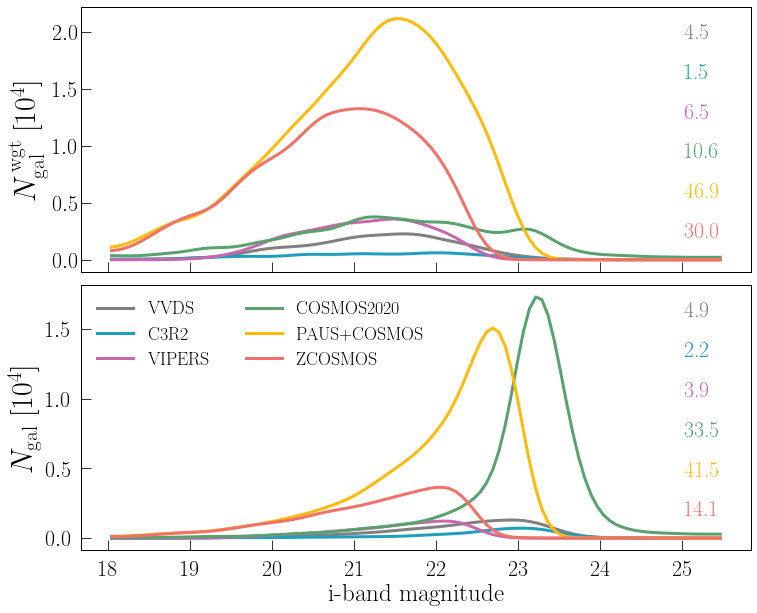

In [5]:
fig, ax = plt.subplots(2, 1, figsize = (12,10), sharex = True)
plt.subplots_adjust(hspace = 0.05, wspace = 0.05)
mag  = 30 - 2.5*np.log10(DF.BDF_FLUX_DERED_CALIB_I.values)
wgt  = DF.DETECTED.values * DF.w.values / 1e4
msk1 = np.isfinite(wgt)
mag, wgt = mag[msk1], wgt[msk1]
bins = np.linspace(18, 25.5, 100 + 1)
c, b = np.histogram(mag, bins = bins, weights = wgt); b = (b[1:] + b[:-1])/2

total = np.size(wgt[np.invert(DF.SOURCE.isna())[msk1]])
total_wgt = np.sum(wgt[np.invert(DF.SOURCE.isna())[msk1]])

i = 0
for S in DF.SOURCE.unique():
    if str(S) == 'nan': continue
    msk  = DF.SOURCE.values[msk1] == S
    
    c, b = np.histogram(mag[msk], bins = bins, weights = wgt[msk]); b = (b[1:] + b[:-1])/2; m = np.sum(c)
    c    = gaussian_filter1d(c, 0.2/(b[1] - b[0]))
    c    = c * m/np.trapz(c, b) 
    a = ax[0].plot(b, c, label = S, lw = 3)
    ax[0].text(0.9, 0.88 - 0.15*i, '%0.1f' %(np.sum(wgt[msk])/total_wgt * 100), color = a[0].get_color(), fontsize = 22, transform = ax[0].transAxes)
    
    c, b = np.histogram(mag[msk], bins = bins, weights = np.ones(msk.sum())/1e4); b = (b[1:] + b[:-1])/2; m = np.sum(c)
    c    = gaussian_filter1d(c, 0.2/(b[1] - b[0]))
    c    = c * m/np.trapz(c, b) 
    a = ax[1].plot(b, c, label = S, lw = 3)
    ax[1].text(0.9, 0.88 - 0.15*i, '%0.1f' %(np.size(wgt[msk])/total * 100), color = a[0].get_color(), fontsize = 22, transform = ax[1].transAxes)
    
    i += 1
ax[1].legend(fontsize = 18, ncol = 2)
plt.tick_params(pad = 10)
ax[1].set_xlabel('i-band magnitude', size = 25)
ax[0].set_ylabel(r'$N^{\rm \, wgt}_{\rm gal}$  [$10^4$]', size = 30)
ax[1].set_ylabel(r'$N_{\rm gal}$  [$10^4$]', size = 30)
plt.savefig('./ZSample_Mag.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

# Now plot the estimate bias

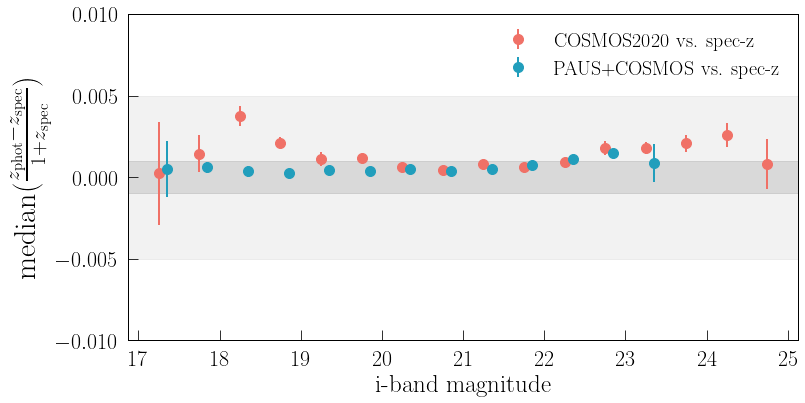

In [9]:
plt.figure(figsize=(12,6))

A = np.loadtxt('/project/chihway/dhayaa/DECADE/Redshift_files/median_bias_Cosmos.txt')
M = A[:, 0] < 25
plt.errorbar(A[M, 0], np.median(A[M, 1:], axis = 1), yerr = np.std(A[M, 1:], axis = 1), 
             lw = 0, elinewidth = 2, markersize = 10, marker = 'o', color = 'C5', label = 'COSMOS2020 vs. spec-z')

A = np.loadtxt('/project/chihway/dhayaa/DECADE/Redshift_files/median_bias_PausCosmos.txt')
plt.errorbar(A[M, 0] + 0.1, np.median(A[M, 1:], axis = 1), yerr = np.std(A[M, 1:], axis = 1), 
             lw = 0, elinewidth = 2, markersize = 10, marker = 'o', color = 'C1', label = 'PAUS+COSMOS vs. spec-z')


plt.xlabel(r'i-band magnitude', size = 25)
plt.ylabel(r'${\rm median}\bigg(\frac{z_{\rm phot} - z_{\rm spec}}{1 + z_{\rm spec}}\bigg)$', size = 30)
plt.ylim(-0.01, 0.01)

plt.axhspan(-0.001, 0.001, color = 'k', alpha = 0.1)
plt.axhspan(-0.005, 0.005, color = 'k', alpha = 0.05)

plt.tick_params(pad = 10)
plt.legend(fontsize = 20)
plt.savefig('./ZSample_Bias.pdf', dpi = 300, bbox_inches = 'tight')